# 2) Compare a representação de dois modelos vetoriais

## Utilizando word2vec

In [10]:
#Gensim do Colab não funciona tem que instalar e reiniciar
!pip install gensim nltk scikit-learn matplotlib numpy

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.0/61.0 kB 4.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.6/60.6 kB 4.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 26.7/26.7 MB 64.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.3/18.3 MB 85.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 38.6/38.6 MB 15.5 MB/s eta 0:00:00
  Attempting uninstall: numpy
    Found existing installation: numpy 2.0.2
    Uninstalling numpy-2.0.2:
      Successfully uninstalled numpy-2.0.2
  Attempting uninstall: scipy
    Found existing installation: scipy 1.14.1
    Uninstalling scipy-1.14.1:
      Successfully uninstalled scipy-1.14.1


In [62]:
# --- 0. Instalação e Imports (Necessário no Colab se não estiver pré-instalado) ---
# Descomente e execute as linhas !pip se receber erro de módulo não encontrado
# !pip install gensim nltk scikit-learn matplotlib numpy

import re # Para expressões regulares (limpeza de texto)
import numpy as np
from gensim.models import Word2Vec
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import matplotlib.cm as cm # Para gerar cores distintas para os pontos
import nltk
import math
from warnings import simplefilter
from scipy.cluster.hierarchy import dendrogram, linkage, ClusterWarning

In [42]:
#pacotes necessários para o tokenizador
nltk.download('punkt')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Marlon\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [43]:
# Baixar o tokenizador 'punkt' do NLTK (necessário na primeira execução no ambiente)
try:
    nltk.data.find('tokenizers/punkt')
except nltk.downloader.DownloadError:
    print("Baixando o tokenizador 'punkt' do NLTK...")
    nltk.download('punkt', quiet=True)
    print("Download concluído.")

print("Bibliotecas importadas e NLTK pronto.")
print("-" * 40)

Bibliotecas importadas e NLTK pronto.
----------------------------------------


In [44]:
# --- 1. Definição dos Textos ---
# Mínimo 6 textos, com pelo menos 2 pares similares.
# Limitando a ~10-12 para clareza na visualização.
texts = [
    "O dia amanheceu ensolarado e agradável.",             # Clima 1
    "Esperamos um fim de semana de sol e céu azul.",       # Clima 2 (similar ao 1)
    "A culinária brasileira usa muitos ingredientes frescos.", # Culinária 1
    "Adoro comer frutas tropicais como manga e abacaxi.",  # Culinária/Frutas 2
    "Feijoada é um prato típico muito saboroso.",          # Culinária 3 (similar ao 3)
    "O gato dorme tranquilamente no sofá.",               # Animais 1
    "Cachorros precisam de passeios diários.",            # Animais 2
    "A noite está estrelada e silenciosa.",               # Clima/Noite 3 (ligeiramente similar ao 1/2)
    "As receitas de família guardam tradições.",          # Culinária 4 (similar ao 3/5)
    "Os cães são animais leais e companheiros.",         # Animais 3 (similar ao 7)
]

# Garantir que não exceda um limite razoável para o plot
max_texts_to_plot = 12
if len(texts) > max_texts_to_plot:
    print(f"Limitando a {max_texts_to_plot} textos para visualização.")
    texts = texts[:max_texts_to_plot]

print(f"Textos de entrada ({len(texts)}):")
for i, t in enumerate(texts):
    print(f"{i}: {t}")
print("-" * 40)

Textos de entrada (10):
0: O dia amanheceu ensolarado e agradável.
1: Esperamos um fim de semana de sol e céu azul.
2: A culinária brasileira usa muitos ingredientes frescos.
3: Adoro comer frutas tropicais como manga e abacaxi.
4: Feijoada é um prato típico muito saboroso.
5: O gato dorme tranquilamente no sofá.
6: Cachorros precisam de passeios diários.
7: A noite está estrelada e silenciosa.
8: As receitas de família guardam tradições.
9: Os cães são animais leais e companheiros.
----------------------------------------


In [45]:
nltk.download('punkt_tab')

[nltk_data] Downloading package punkt_tab to
[nltk_data]     C:\Users\Marlon\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


True

In [46]:
# --- 2. Pré-processamento ---
def preprocess_text(text):
    """Limpa e tokeniza o texto."""
    # Converte para minúsculas
    text = text.lower()
    # Remove pontuações básicas e números (opcional, mas ajuda a focar nas palavras)
    text = re.sub(r'[^\w\s]', '', text) # Remove pontuação
    text = re.sub(r'\d+', '', text)      # Remove números
    # Tokeniza (divide em palavras)
    tokens = nltk.word_tokenize(text, language='portuguese') # Especificar idioma ajuda
    # Remove palavras vazias (stopwords) - Opcional, pode ou não ajudar com poucos dados
    from nltk.corpus import stopwords
    nltk.download('stopwords') # Se for usar
    stop_words = set(stopwords.words('portuguese'))
    tokens = [word for word in tokens if word not in stop_words and len(word) > 1] # Remove stopwords e palavras de 1 letra
    tokens = [word for word in tokens if len(word) > 1] # Apenas remove palavras de 1 letra
    return tokens

tokenized_texts = [preprocess_text(t) for t in texts]

print("Textos Tokenizados (Exemplo do primeiro):")
print(tokenized_texts[0])
print("-" * 40)

Textos Tokenizados (Exemplo do primeiro):
['dia', 'amanheceu', 'ensolarado', 'agradável']
----------------------------------------


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Marlon\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Marlon\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Marlon\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Marlon\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Marlon\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Marlon\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package st

In [47]:
# --- 3. Treinamento do Modelo Word2Vec ---
# Parâmetros importantes para datasets pequenos:
# min_count=1: Inclui todas as palavras. Essencial aqui.
# epochs: Aumentar o número de épocas de treino.
# vector_size: Dimensão dos vetores (100 é comum, mas 50 pode ser suficiente aqui).
# window: Contexto de palavras vizinhas.
# sg=1: Usa Skip-gram (geralmente melhor para datasets menores).

vector_dim = 50  # Dimensão dos vetores de palavras
w2v_model = Word2Vec(sentences=tokenized_texts,
                     vector_size=vector_dim,
                     window=3,         # Janela menor pode ser melhor para frases curtas
                     min_count=1,      # Crucial para datasets pequenos
                     workers=4,        # Número de threads (ajuste conforme CPU disponível no Colab)
                     sg=1,             # Skip-gram
                     epochs=100)       # Mais épocas para compensar poucos dados

print("Modelo Word2Vec treinado.")
print(f"Tamanho do vocabulário: {len(w2v_model.wv.index_to_key)}")
# Exemplo: Palavras mais similares a 'sol' (se 'sol' estiver no vocabulário)
try:
    similar_words = w2v_model.wv.most_similar('sol', topn=3)
    print(f"Palavras mais similares a 'sol': {similar_words}")
except KeyError:
    print("Palavra 'sol' não encontrada no vocabulário (corpus muito pequeno).")
print("-" * 40)


Modelo Word2Vec treinado.
Tamanho do vocabulário: 45
Palavras mais similares a 'sol': [('culinária', 0.5437578558921814), ('sofá', 0.435198038816452), ('leais', 0.4049411416053772)]
----------------------------------------


In [48]:
# --- 4. Cálculo dos Vetores de Sentenças ---
# Estratégia: Média dos vetores das palavras na sentença

def get_sentence_vector(tokens, model, vector_size):
    """Calcula o vetor médio para uma lista de tokens."""
    vector = np.zeros(vector_size)
    count = 0
    for word in tokens:
        if word in model.wv: # Checa se a palavra está no vocabulário do modelo
            vector += model.wv[word]
            count += 1
    if count > 0:
        vector /= count # Calcula a média
    # else: # Opcional: Lidar com sentenças onde nenhuma palavra está no vocabulário
    #     print(f"Aviso: Sentença com tokens '{tokens}' não possui palavras no vocabulário.")
    return vector
# Calcula o vetor para cada texto tokenizado
sentence_vectors = np.array([get_sentence_vector(tokens, w2v_model, vector_dim)
                             for tokens in tokenized_texts])

print(f"Vetores das sentenças calculados. Shape: {sentence_vectors.shape}")
# Verificar se há vetores nulos (indicativo de problemas)
if np.any(np.all(sentence_vectors == 0, axis=1)):
    print("AVISO: Uma ou mais sentenças resultaram em vetor nulo (nenhuma palavra no vocabulário?).")
print("-" * 40)



Vetores das sentenças calculados. Shape: (10, 50)
----------------------------------------


In [ ]:
# --- 5. Redução de Dimensionalidade com PCA ---
# Reduzir os vetores de 'vector_dim' dimensões para 2 dimensões para plotagem

pca = PCA(n_components=3, random_state=42) # random_state para reprodutibilidade
pca_result = pca.fit_transform(sentence_vectors)

print(f"Vetores reduzidos para 2D com PCA. Shape: {pca_result.shape}")
print("Componentes Principais (x, y, z) para cada sentença:")

pca_result = pca_result * 100 #Multiplicado por 100 para melhor visualização nos gráficos.

for i, (x, y, z) in enumerate(pca_result):
    print(f"Texto {i}: ({x:.4f}, {y:.4f}, {z:.4f})")
print("-" * 40)

Vetores reduzidos para 2D com PCA. Shape: (10, 3)
Componentes Principais (x, y, z) para cada sentença:
Texto 0: (1.2711, -0.7510, -1.7291)
Texto 1: (-1.0635, -0.4518, 1.2610)
Texto 2: (1.4285, -0.0374, 2.3425)
Texto 3: (-0.9540, 0.7308, 0.8011)
Texto 4: (2.6793, -1.7515, -0.6847)
Texto 5: (-0.4938, -1.8525, -1.4750)
Texto 6: (0.1669, 4.3752, -0.4734)
Texto 7: (-4.2354, -0.7816, -0.7183)
Texto 8: (0.9336, 1.2352, -1.6225)
Texto 9: (0.2673, -0.7154, 2.2983)
----------------------------------------


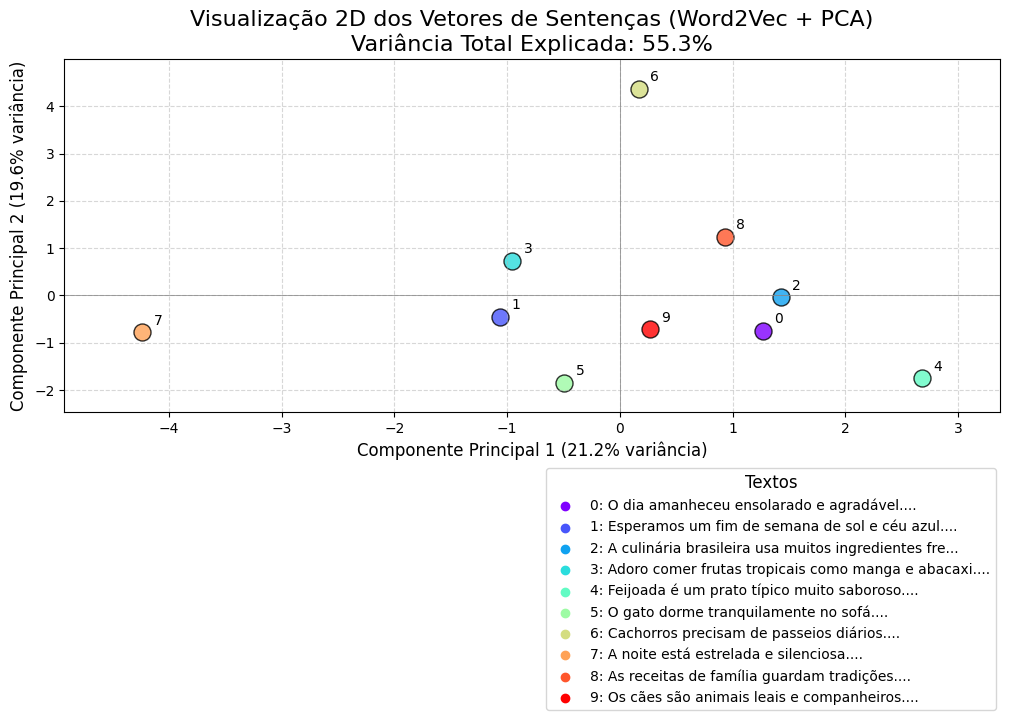


--- Interpretação do Gráfico ---
O gráfico acima mostra cada texto original como um ponto no espaço 2D.
A posição de cada ponto é determinada pelo vetor da sentença (média dos vetores das palavras) após a redução com PCA.
Textos com conteúdo semanticamente similar (segundo o modelo Word2Vec) devem aparecer mais próximos uns dos outros.
Com um corpus pequeno, as relações capturadas pelo Word2Vec podem ser fracas ou baseadas em coocorrências simples de palavras.


In [56]:
# --- 6. Visualização dos Vetores 2D ---
#
plt.figure(figsize=(12, 9)) # Ajuste o tamanho conforme necessário

# Gerar cores distintas para cada ponto usando um colormap
colors = cm.rainbow(np.linspace(0, 1, len(texts)))

# Plotar cada ponto (vetor 2D da sentença)
for i, (x, y, z) in enumerate(pca_result):
    plt.scatter(x, y, color=colors[i], s=150, alpha=0.8, edgecolors='k')
    # Adicionar anotação (número do texto) ligeiramente deslocado do ponto
    plt.text(x + 0.1, y + 0.1, str(i), fontsize=10, ha='left', va='bottom')

# Variância explicada
explained_variance_ratio = pca.explained_variance_ratio_
total_explained_variance = explained_variance_ratio.sum() * 100

plt.title(f'Visualização 2D dos Vetores de Sentenças (Word2Vec + PCA)\nVariância Total Explicada: {total_explained_variance:.1f}%', fontsize=16)
plt.xlabel(f'Componente Principal 1 ({explained_variance_ratio[0]*100:.1f}% variância)', fontsize=12)
plt.ylabel(f'Componente Principal 2 ({explained_variance_ratio[1]*100:.1f}% variância)', fontsize=12)
plt.grid(True, linestyle='--', alpha=0.5)

legend_handles = [plt.scatter([], [], color=colors[i], label=f'{i}: {texts[i][:50]}...')
                  for i in range(len(texts))]
plt.legend(handles=legend_handles, loc='center left', bbox_to_anchor=(0.5, -0.5),
           fontsize='medium', title="Textos", title_fontsize='large', borderaxespad=1.)

plt.margins(0.1)
plt.axhline(0, color='grey', lw=0.5)
plt.axvline(0, color='grey', lw=0.5)

plt.tight_layout(rect=[0, 0, 0.85, 1])
plt.show()

print("\n--- Interpretação do Gráfico ---")
print("O gráfico acima mostra cada texto original como um ponto no espaço 2D.")
print("A posição de cada ponto é determinada pelo vetor da sentença (média dos vetores das palavras) após a redução com PCA.")
print("Textos com conteúdo semanticamente similar (segundo o modelo Word2Vec) devem aparecer mais próximos uns dos outros.")
print("Com um corpus pequeno, as relações capturadas pelo Word2Vec podem ser fracas ou baseadas em coocorrências simples de palavras.")

centro 
 [3.60822483e-16 5.88418203e-16 0.00000000e+00]
True
Variancia:  [0.38298175 0.3538612  0.26315705]
[[-1.27110884 -0.75096487]
 [ 1.06354172 -0.45177249]
 [-1.4285475  -0.03737487]
 [ 0.95398327  0.73075506]
 [-2.67926039 -1.7515226 ]
 [ 0.49384291 -1.85247001]
 [-0.166852    4.37519545]
 [ 4.23535249 -0.78164486]
 [-0.93363894  1.23521256]
 [-0.26731272 -0.71541337]]


C:\Users\Marlon\AppData\Local\Temp\ipykernel_25012\4171300812.py:24: RuntimeWarning: invalid value encountered in divide
  z = (R[0, 2] * x1 + R[1, 2] * x2) / (1 - R[2, 2])


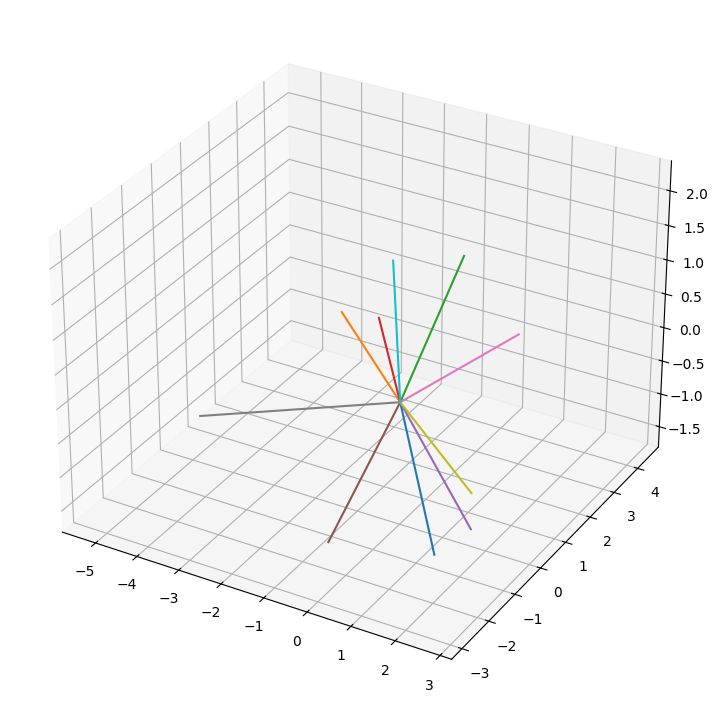

In [57]:
centro = pca_result.mean(axis=0)
v_centro = pca_result - centro

print('centro','\n',centro)
print( np.allclose(pca_result, v_centro+centro))

# obter o plano para projeção ortogonal
U,s,Vh = np.linalg.svd(v_centro)
print('Variancia: ', np.square(s) / np.square(s).sum() )
W2 = Vh.T[:, :2]
v1_plano = Vh.T[:, 0]
v2_plano = Vh.T[:, 1]
projetados2d = v_centro.dot(W2)
print(projetados2d)
# calculando o plano de projeção
menor = np.min(pca_result,axis=0)-1
maior = np.min(pca_result,axis=0)+1
x1s = np.linspace(menor[0], maior[0], 10)
y1s = np.linspace(menor[1], maior[1], 10)
z1s = np.linspace(menor[2], maior[2], 10)
C = Vh
R = C.T.dot(C)
x1, x2 = np.meshgrid(x1s, y1s)
z = (R[0, 2] * x1 + R[1, 2] * x2) / (1 - R[2, 2])
#
# tentando visualizar as projeções no espaço 3d
fig = plt.figure(figsize=(12, 9)) # Ajuste o tamanho conforme necessário
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(x1, x2, z, alpha=0.2, color="k")
#ax.view_init(elev=180, azim=180)
# pontos originais
for v in pca_result:
    xs = np.linspace(0, v[0], 10)
    ys = np.linspace(0, v[1], 10)
    zs = np.linspace(0, v[2], 10)
    plt.plot(xs,ys,zs=zs)
plt.show()

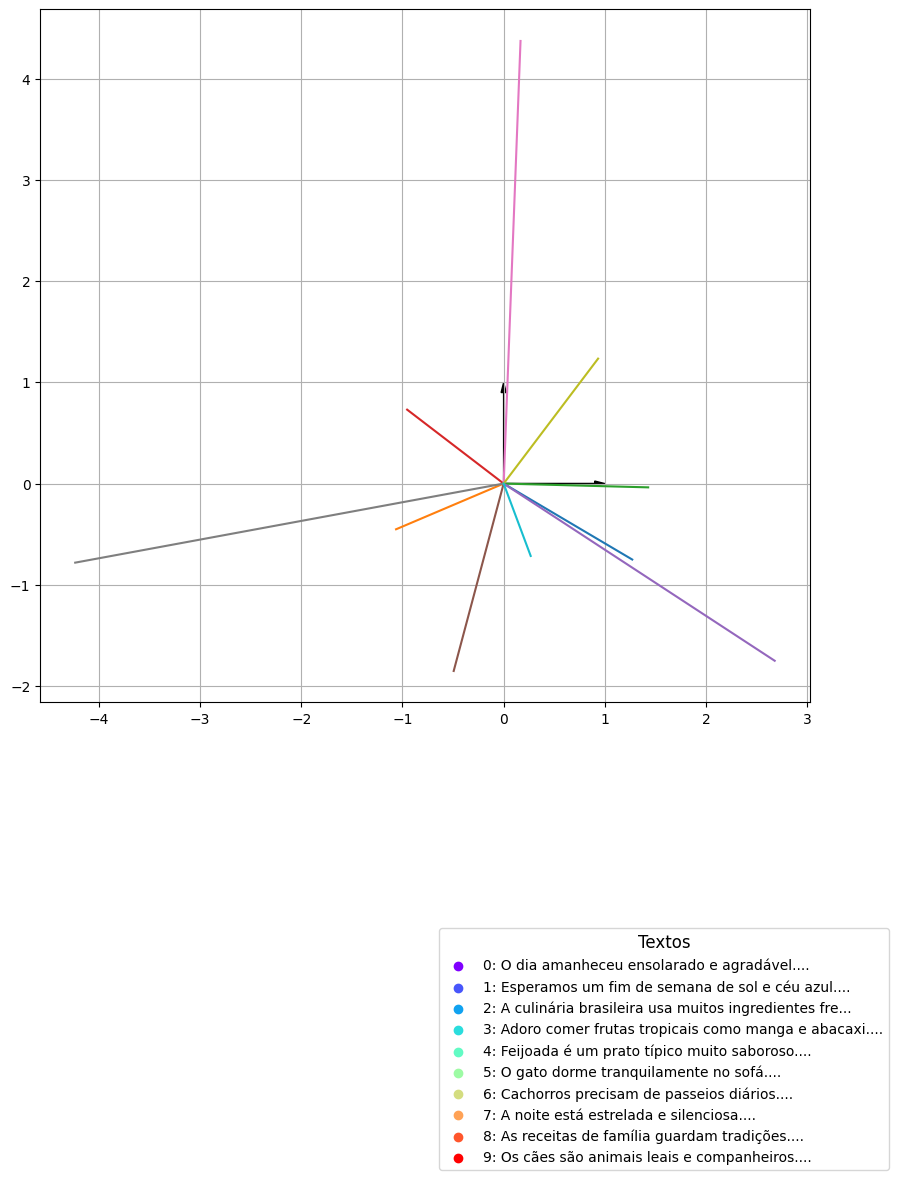

In [55]:
fig = plt.figure(figsize=(12, 9))
ax = fig.add_subplot(111, aspect='equal')
# pontos projetados
for v in pca_result:
    xs = np.linspace(0, v[0], 10)
    ys = np.linspace(0, v[1], 10)
    ax.plot(xs,ys)

ax.arrow(0, 0, 0, 1, head_width=0.05, \
        length_includes_head=True, head_length=0.1, fc='k', ec='k')
ax.arrow(0, 0, 1, 0, head_width=0.05, \
        length_includes_head=True, head_length=0.1, fc='k', ec='k')
ax.grid(True)
#plt.xscale('log')
#plt.yscale('log')
#plt.xlim(-0.05,0.05)
#plt.ylim(-0.05,0.05)
plt.legend(handles=legend_handles, loc='center left', bbox_to_anchor=(0.5, -0.5),
           fontsize='medium', title="Textos", title_fontsize='large', borderaxespad=1.)
plt.show()

original
[[0.         3.80533889 4.13665256 3.68081341 2.01861693 2.09593333
  5.39199259 5.59854926 2.01746176 4.15077572]
 [3.80533889 0.         2.74807968 1.27352303 4.41400799 3.12602048
  5.27462352 3.75322972 3.89216907 1.70785602]
 [4.13665256 2.74807968 0.         2.93979791 3.6968091  4.64364198
  5.38443603 6.48091329 4.19351248 1.3454198 ]
 [3.68081341 1.27352303 2.93979791 0.         4.644317   3.47352133
  4.02027902 3.91960616 3.11309213 2.41343124]
 [2.01861693 4.41400799 3.6968091  4.644317   0.         3.27160081
  6.62521647 6.98238247 3.58430857 3.97357349]
 [2.09593333 3.12602048 4.64364198 3.47352133 3.27160081 0.
  6.34219604 3.96461039 3.40488515 4.01374345]
 [5.39199259 5.27462352 5.38443603 4.02027902 6.62521647 6.34219604
  0.         6.78471573 3.43041905 5.79715583]
 [5.59854926 3.75322972 6.48091329 3.91960616 6.98238247 3.96461039
  6.78471573 0.         5.62171962 5.420185  ]
 [2.01746176 3.89216907 4.19351248 3.11309213 3.58430857 3.40488515
  3.4304190

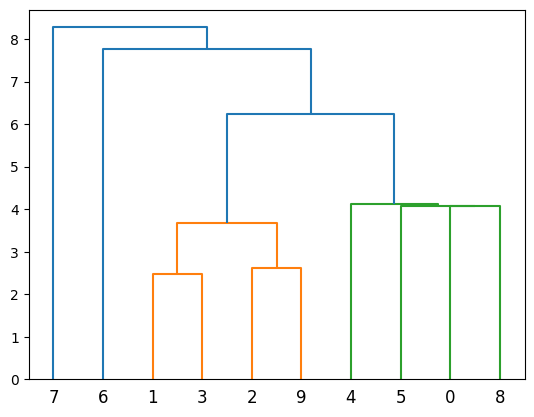

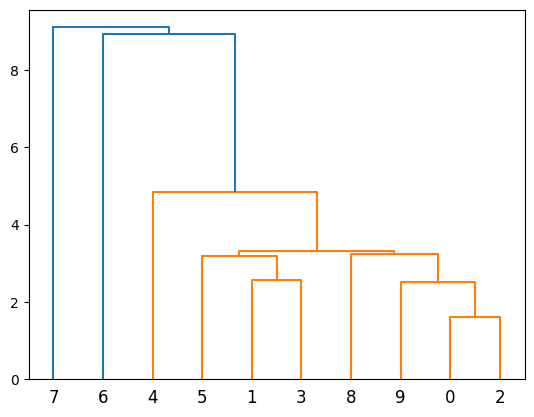

In [63]:
def vectorDistance(v1,v2):
    soma = 0
    for i in range(0,len(v1)):
        d = v1[i]-v2[i]
        soma = soma + d*d
    return math.sqrt(soma)

def calcDistance(mat):
    nrows = len(mat)
    ncols = len(mat[0])
    res = np.zeros( (nrows,nrows) )
    for i in range(0,nrows):
        m1 = mat[i]
        for j in range(0,nrows):
            if i!=j:
                m2 = mat[j]
                res[i][j] = vectorDistance(m1,m2)
            else:
                res[i][j] = 0
    return res

d = calcDistance(pca_result)
d1 = calcDistance(projetados2d)
print('original')
print(d)
print('projetada')
print(d1)


simplefilter("ignore", ClusterWarning)
Z1 = linkage(d, 'single')
fig = plt.figure()
dn = dendrogram(Z1)
plt.show()
Z2 = linkage(d1, 'single')
fig = plt.figure()
dn = dendrogram(Z2)
plt.show()
